In [1]:
import tensorflow as  tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
from pathlib import Path
import shutil
import datetime
from functools import partial

In [2]:
sys.path.append('../utils')

In [3]:
from data_preparing import ChannelData, random_rotation
from model import ChannelCutter
from focal_tversky_loss import *

In [8]:
train_data = ChannelData(
    path=Path('../data/crop_arkansas_512x320/train'),
    elevation='elevation'
)
val_data = ChannelData(
    path=Path('../data/crop_arkansas_512x320/val'),
    elevation='elevation'
)
train_data.add_process(random_rotation)
val_data.add_process(random_rotation)

model = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})


BATCH_SIZE = 2
BUFFER_SIZE = 6

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

loss = IOULoss(fp_weight=0.25)
# used for model name tagging
session_labels = ['arkansas', 'crop512x320', 'no_rotation', 'fp025']

# first run use fild_lr to find learning rate
find_lr = False

In [5]:
from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 336, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

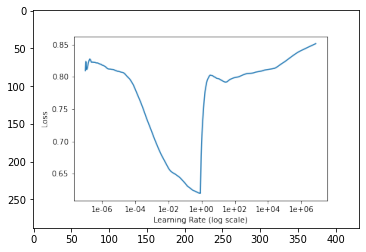

In [6]:
image_name = 'logs/lr_' + '_'.join(session_labels) + '.png'
if find_lr:
    model.compile_model(
        optimizer='adam', 
        loss=loss.loss, 
        metrics=['accuracy']
    )

    lr_finder = LRFinder(start_lr=1e-7, end_lr=10, max_steps=336)
    model.unet.fit(
        train_dataset, epochs=2, 
        callbacks=[lr_finder]
    )
    
    lr_finder.plot()
    plt.savefig(image_name)
else:
    img = mpimg.imread(image_name)
    plt.imshow(img)
    plt.show()

In [7]:
model.unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 320, 4) 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, 512, 320, 32) 6304        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 320, 32) 128         input_conv[0][0]                 
__________________________________________________________________________________________________
pre_unet_conv_step0 (Conv2D)    (None, 512, 320, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

In [9]:
initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.1,
    staircase=True)

model.compile_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss=reduced_iou_loss, 
    metrics=['accuracy', tp, tn]
)

session_labels.append('lr1e-3_to_lr1e-4')
session_name = '_'.join(session_labels)
save_path = Path("./logs") / session_name / ('trained_on_'+str(datetime.datetime.now()))
os.makedirs(save_path)
# callback that records training metrics for diagnosis
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=save_path)
# callback that stops training if the monitored metric doesn't improve after specified epochs of training (patience)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_dataset =  train_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_dataset =  val_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.unet.fit(
    train_dataset, epochs=10, validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/10
  1/292 [..............................] - ETA: 0s - loss: 0.9202 - accuracy: 0.6638 - tp: 0.5420 - tn: 0.6681WARNING:tensorflow:From /home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
292/292 [==============================] - 150s 514ms/step - loss: 0.5941 - accuracy: 0.9499 - tp: 0.6212 - tn: 0.9612 - val_loss: 0.9394 - val_accuracy: 0.0720 - val_tp: 0.9996 - val_tn: 0.0431
Epoch 2/10
292/292 [==============================] - 151s 516ms/step - loss: 0.4731 - accuracy: 0.9708 - tp: 0.5763 - tn: 0.9844 - val_loss: 0.4916 - val_accuracy: 0.9627 - val_tp: 0.6483 - val_tn: 0.9728
Epoch 3/10
292/292 [==============================] - 151s 516ms/step - loss: 0.4492 - accuracy: 0.9726 - tp: 0.5889 - tn: 0.9857 - val_loss: 0.4737 - val_accur

In [10]:
import json

In [11]:
with open(save_path / 'model_config.json', 'w') as fp:
    fp.write(str(model.unet.get_config()))

In [12]:
model_path = str(save_path).replace('logs', 'models')
os.makedirs(model_path)

In [13]:
model.unet.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/arkansas_crop512x320_no_rotation_fp025_lr1e-3_to_lr1e-4/trained_on_2020-09-25 20:20:25.648688/assets


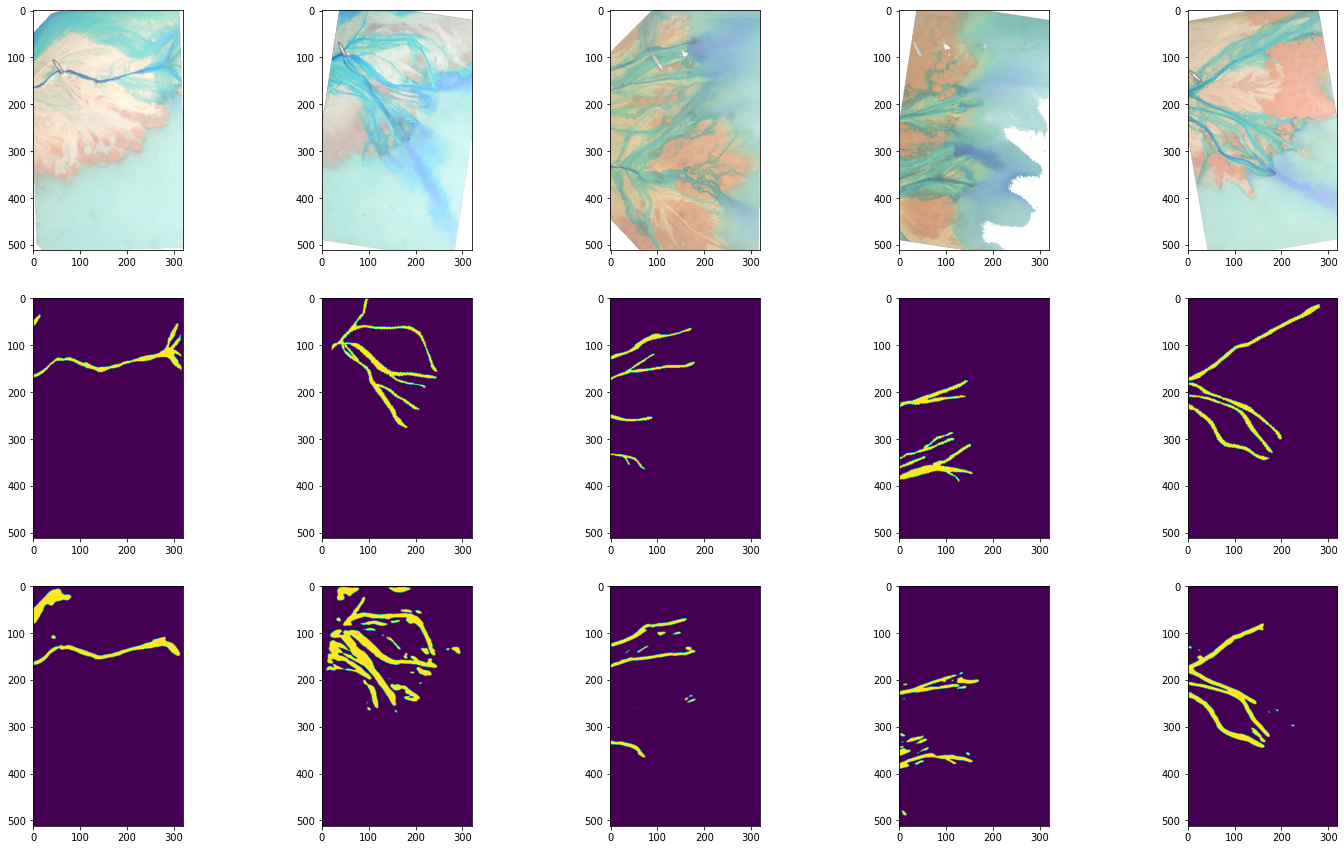

<Figure size 432x288 with 0 Axes>

In [14]:
n_samples = 5

fig, axes = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples*5, 15))
i = 0
tf.random.set_seed(2)
for x, y in val_dataset.take(5):
    axes[0][i].imshow(x[0, :, : :])
    axes[1][i].imshow(y[0, :, : :])
    axes[2][i].imshow(model.unet.predict(x)[0, :, :, 1])
    i += 1

plt.show()
plt.savefig(save_path / 'example_vals_1.png')